# Distribution des naissances dans le temps 

Dans ce carnet est proposée une analyse de la distribution dans le temps des années de naissance de la population retenue, et la mise en évidence de générations.

On met aussi en évidence l'évolution dans le temps des genres

In [18]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

In [19]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [20]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [21]:
## define SPARQL enpoint
endpoint = "https://ag1gha303ygjmx4r.allegrograph.cloud/repositories/As-de-la-Guerre"

In [22]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?ace
       (SAMPLE(?label) AS ?aceLabel)
       (SAMPLE(?allegLabel) AS ?allegiance)
       (SAMPLE(?birthDate) AS ?birthDate)
       (SAMPLE(?birthYearRaw) AS ?birthYear)
       (SAMPLE(?deathDate) AS ?deathDate)
       (SAMPLE(?deathYearRaw) AS ?deathYear)
WHERE {
  GRAPH <https://github.com/samohTDNM/as-ww1/blob/main/docs/wikidata-import.md> {
    ?ace rdfs:label ?label ;
         wdt:P106 wd:Q2095549 ;
         wdt:P945 ?alleg .

    ?alleg rdfs:label ?allegLabel .

    OPTIONAL { 
      ?ace wdt:P569 ?birthDate .
      BIND(xsd:integer(SUBSTR(STR(?birthDate), 1, 4)) AS ?birthYearRaw)
    }
    OPTIONAL { 
      ?ace wdt:P570 ?deathDate .
      BIND(xsd:integer(SUBSTR(STR(?deathDate), 1, 4)) AS ?deathYearRaw)
    }
  }
}
GROUP BY ?ace
ORDER BY ?birthYear


"""

In [23]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [24]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

957


[['http://www.wikidata.org/entity/Q6225085',
  'John Capper',
  'United Kingdom of Great Britain and Ireland',
  '1861-12-07T00:00:00Z',
  '1861',
  '1955-05-24T00:00:00Z',
  '1955'],
 ['http://www.wikidata.org/entity/Q3724015',
  'Emanuele Vittorio Parodi',
  'Kingdom of Italy',
  '1862-01-22T00:00:00Z',
  '1862',
  '1945-04-13T00:00:00Z',
  '1945'],
 ['http://www.wikidata.org/entity/Q57569',
  'Prince Henry of Prussia',
  'Germany',
  '1862-08-14T00:00:00Z',
  '1862',
  '1929-04-20T00:00:00Z',
  '1929']]

In [25]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(r)
df_p.columns = [
    'personUri',
    'personLabel',
    'allegiance',
    'birthDate',
    'birthYear',
    'deathDate',
    'deathYear'
]
df_p.head()


,personUri,personLabel,allegiance,birthDate,birthYear,deathDate,deathYear
0,http://www.wikidata.org/entity/Q6225085,John Capper,United Kingdom of Great Britain and Ireland,1861-12-07T00:00:00Z,1861,1955-05-24T00:00:00Z,1955
1,http://www.wikidata.org/entity/Q3724015,Emanuele Vittorio Parodi,Kingdom of Italy,1862-01-22T00:00:00Z,1862,1945-04-13T00:00:00Z,1945
2,http://www.wikidata.org/entity/Q57569,Prince Henry of Prussia,Germany,1862-08-14T00:00:00Z,1862,1929-04-20T00:00:00Z,1929
3,http://www.wikidata.org/entity/Q193236,Gabriele D'Annunzio,Kingdom of Italy,1863-03-12T00:00:00Z,1863,1938-03-01T00:00:00Z,1938
4,http://www.wikidata.org/entity/Q1337203,Emile Reymond,France,1865-04-09T00:00:00Z,1865,1914-10-22T00:00:00Z,1914


In [26]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    957 non-null    object
 1   personLabel  957 non-null    object
 2   allegiance   957 non-null    object
 3   birthDate    957 non-null    object
 4   birthYear    957 non-null    object
 5   deathDate    957 non-null    object
 6   deathYear    957 non-null    object
dtypes: object(7)
memory usage: 52.5+ KB


### Ajouter une colonne au DataFrame avec l'allégeance nettoyée'

In [27]:
#on normalize
df_p['allegiance'] = df_p['allegiance'].str.strip()


In [28]:
# la fonction, voir autres notebooks
allegiance_clean_map = {
    "Kingdom of Italy": "Italy",
    "Italy": "Italy",
    "United Kingdom of Great Britain and Ireland": "United Kingdom",
    "United Kingdom": "United Kingdom",
    "British Empire": "United Kingdom",
    "Germany": "Germany",
    "German Empire": "Germany",
    "German Reich": "Germany",
    "Nazi Germany": "Germany",
    "Austria-Hungary": "Austria-Hungary",
    "Austria–Hungary": "Austria-Hungary",  # en-dash
    "Austria": "Austria-Hungary",
    "Second Polish Republic": "Poland",
    "Kingdom of Romania": "Romania",
    "Kingdom of Hungary": "Hungary",
    "Hungary": "Hungary",
    "Russian Empire": "Russia",
    "Soviet Union": "Russia",
}


In [29]:
df_p['allegiance_clean'] = df_p['allegiance'].replace(allegiance_clean_map)


In [30]:
df_p['allegiance_clean'] = df_p['allegiance'].replace(allegiance_clean_map)

df_p_allegiance_clean = df_p.groupby('allegiance_clean').size().reset_index(name='effectif')
df_p_allegiance_clean = df_p_allegiance_clean.sort_values('effectif', ascending=False)

print(df_p_allegiance_clean.head(30))



      allegiance_clean  effectif
10              France       255
31      United Kingdom       125
15               Italy       122
32       United States       118
11             Germany        86
24              Poland        63
1            Australia        44
6               Canada        35
27              Russia        30
2      Austria-Hungary        19
3              Belgium         9
21         New Zealand         7
5             Bulgaria         5
13             Hungary         4
29        South Africa         4
26             Romania         4
23      Ottoman Empire         3
14             Ireland         3
30              Sweden         2
25            Portugal         2
22              Norway         2
18  Kingdom of Prussia         2
0            Argentina         1
4               Brazil         1
7                Chile         1
8           Costa Rica         1
9       Czechoslovakia         1
17  Kingdom of Bavaria         1
16               Japan         1
12        

## Effectifs par année

In [31]:
### On inspecte les valeurs de la colonne 'birthYear' 
# et on observe que le type de données est 'object', ici texte
df_p['deathYear'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 957 entries, 0 to 956
Series name: deathYear
Non-Null Count  Dtype 
--------------  ----- 
957 non-null    object
dtypes: object(1)
memory usage: 7.6+ KB


In [32]:
### On s'assure de bien avoir des dates. 
df_p['deathDate'] = pd.to_datetime(df_p['deathDate'], errors='coerce')
df_p['birthDate'] = pd.to_datetime(df_p['birthDate'], errors='coerce')

In [33]:
## on extrait les jours, mois et années
df_p['deathYear'] = df_p['deathDate'].dt.year
df_p['deathMonth'] = df_p['deathDate'].dt.month
df_p['deathDay'] = df_p['deathDate'].dt.day


In [34]:
## on vérifie le résulat
df_p[['deathDate', 'deathYear', 'deathMonth', 'deathDay']].head()


,deathDate,deathYear,deathMonth,deathDay
0,1955-05-24 00:00:00+00:00,1955.0,5.0,24.0
1,1945-04-13 00:00:00+00:00,1945.0,4.0,13.0
2,1929-04-20 00:00:00+00:00,1929.0,4.0,20.0
3,1938-03-01 00:00:00+00:00,1938.0,3.0,1.0
4,1914-10-22 00:00:00+00:00,1914.0,10.0,22.0


In [51]:


# On filtre pour des dates de mort pendant 14-18
df_p['deathDate'] = pd.to_datetime(df_p['deathDate'], errors='coerce')
ww1_start = pd.to_datetime('1914-07-28', utc=True)
ww1_end = pd.to_datetime('1918-11-11', utc=True)

df_ww1_deaths = df_p[
    (df_p['deathDate'] >= ww1_start) &
    (df_p['deathDate'] <= ww1_end)
].copy()


In [52]:
### On transforme en DataFrame le résultat du regroupement par année, toutes périodes confondues
deaths_count = (
    df_p[df_p['deathYear'] < 2001]
    .groupby('deathYear')
    .size()
    .reset_index(name='effectif')
    .rename(columns={'deathYear': 'year'})
)

deaths_count


,year,effectif
0,1914.0,5
1,1915.0,9
2,1916.0,22
3,1917.0,61
4,1918.0,68
...,...,...
79,1993.0,7
80,1994.0,1
81,1995.0,1
82,1997.0,2


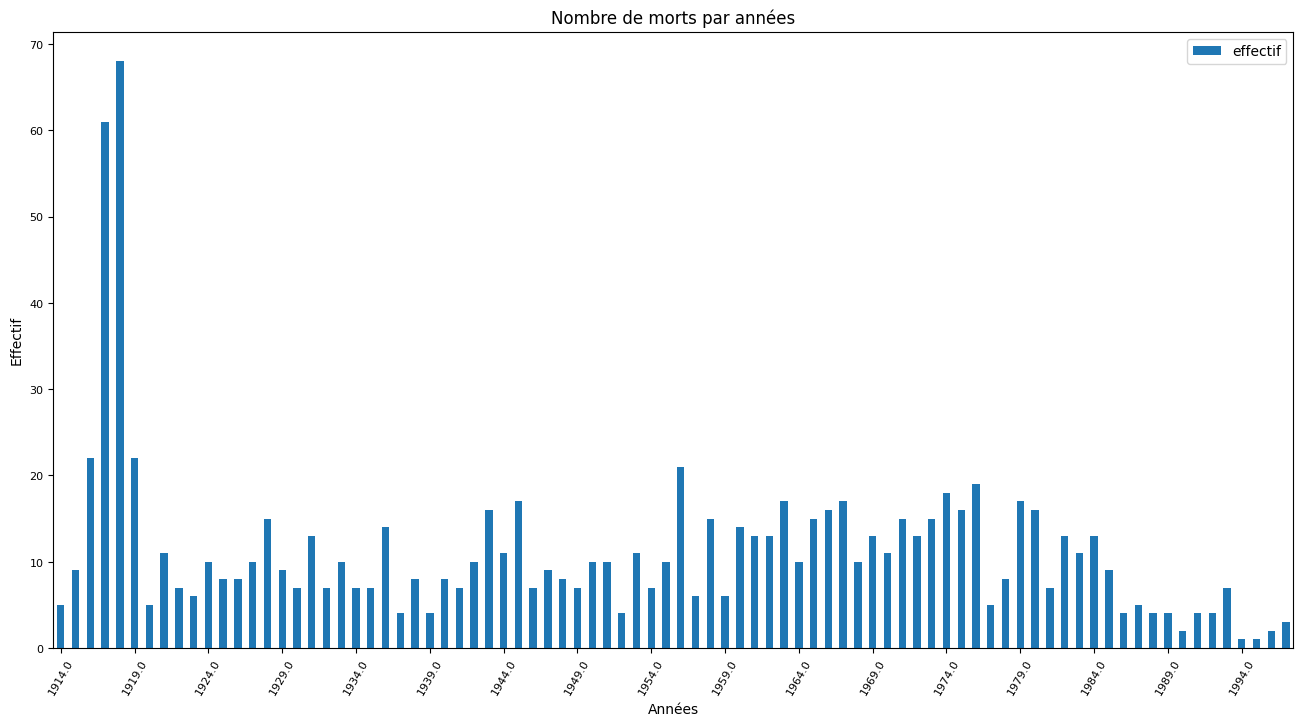

In [40]:
### Représentation graphique des effectifs par année

ax =deaths_count.plot(x='year', y='effectif', kind='bar',rot=60, fontsize=8, figsize=(16,8))


max_xticks = 20
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)

plt.ylabel('Effectif')
plt.xlabel('Années')
plt.title('Nombre de morts par années')
plt.show()

## On se concentre sur les morts durant 14-18

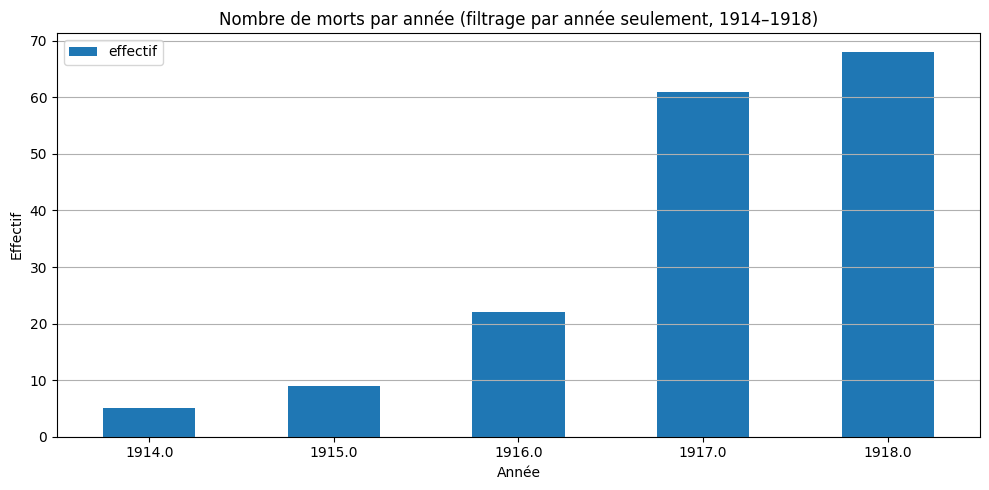

In [53]:
## on regarde les morts uniquements pendant 14-18

df_ww1_by_year = (
    df_p[
        (df_p['deathYear'] >= 1914) & 
        (df_p['deathYear'] <= 1918)
    ]
    .groupby('deathYear')
    .size()
    .reset_index(name='effectif')
    .rename(columns={'deathYear': 'year'})
    .sort_values('year')
)

ax = df_ww1_by_year.plot(
    x='year', y='effectif', kind='bar',
    rot=0, figsize=(10, 5)
)

plt.title("Nombre de morts par année (filtrage par année seulement, 1914–1918)")
plt.xlabel("Année")
plt.ylabel("Effectif")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

C:\Users\menou\AppData\Local\Temp\ipykernel_24424\3974172042.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_ww1_by_month['year_month'] = df_ww1_by_month['deathDate'].dt.to_period('M').astype(str)


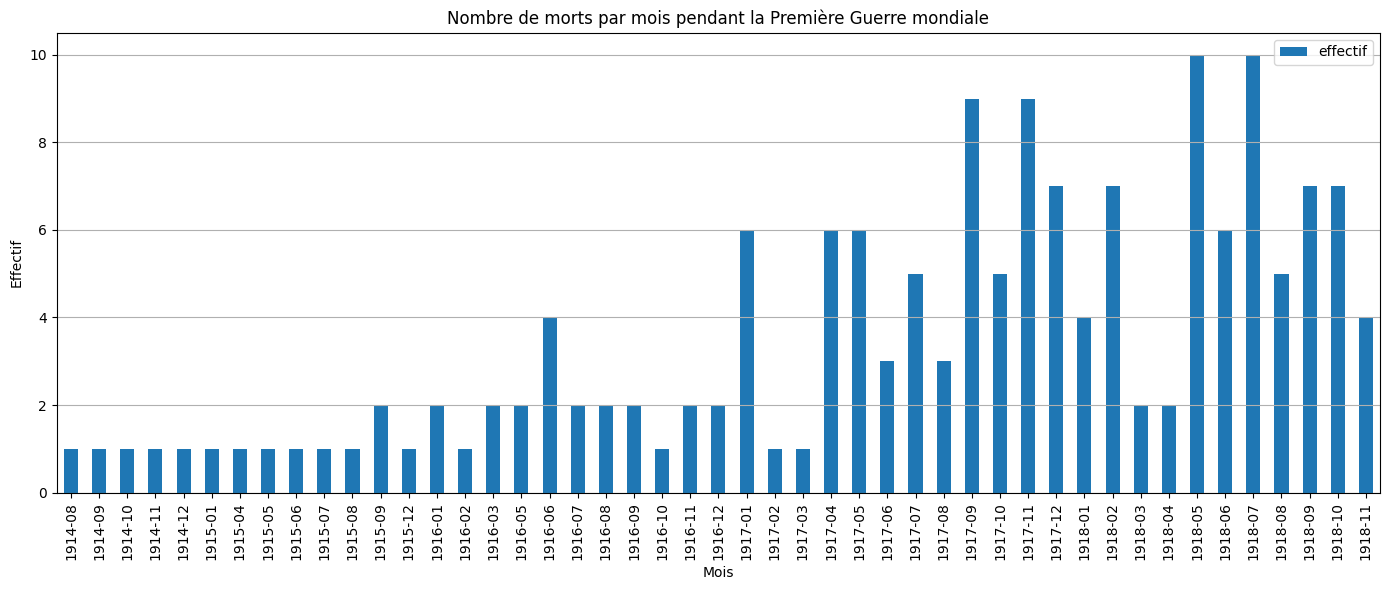

In [57]:
# Représentation des morts pendant la guerre (dates précises)
df_p['deathDate'] = pd.to_datetime(df_p['deathDate'], errors='coerce', utc=True)



# Group by year_month
df_ww1_by_month = df_p[
    (df_p['deathDate'] >= ww1_start) & 
    (df_p['deathDate'] <= ww1_end)
].copy()

df_ww1_by_month['year_month'] = df_ww1_by_month['deathDate'].dt.to_period('M').astype(str)
df_ww1_by_month_grouped = (
    df_ww1_by_month
    .groupby('year_month')
    .size()
    .reset_index(name='effectif')
)
# Plot
ax = df_ww1_by_month_grouped.plot(
    x='year_month', y='effectif', kind='bar',
    figsize=(14, 6)
)

plt.title("Nombre de morts par mois pendant la Première Guerre mondiale")
plt.xlabel("Mois")
plt.ylabel("Effectif")
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()



### Codage par période de cinq ans
On peut s'attendre à une période de surmortalité claire pendant 14-18, mais cela peut toujours être intéressant de vérifier ce fait. 

In [58]:
# Créer une copie indépendante filtrée pour les années de décès raisonnables
cdf_deaths = df_p[df_p['deathYear'] < 2001].copy(deep=True)

In [59]:
cdf_deaths.head(3)

,personUri,personLabel,allegiance,birthDate,birthYear,deathDate,deathYear,allegiance_clean,deathMonth,deathDay
0,http://www.wikidata.org/entity/Q6225085,John Capper,United Kingdom of Great Britain and Ireland,1861-12-07 00:00:00+00:00,1861,1955-05-24 00:00:00+00:00,1955.0,United Kingdom,5.0,24.0
1,http://www.wikidata.org/entity/Q3724015,Emanuele Vittorio Parodi,Kingdom of Italy,1862-01-22 00:00:00+00:00,1862,1945-04-13 00:00:00+00:00,1945.0,Italy,4.0,13.0
2,http://www.wikidata.org/entity/Q57569,Prince Henry of Prussia,Germany,1862-08-14 00:00:00+00:00,1862,1929-04-20 00:00:00+00:00,1929.0,Germany,4.0,20.0


In [63]:
### Créer une liste d'années pour séparer en périodes de 5 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_5_deaths = list(range(1909, 2005, 5))
print(l_5_deaths[:5], l_5_deaths[-5:])

[1909, 1914, 1919, 1924, 1929] [1984, 1989, 1994, 1999, 2004]


In [64]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

cdf_deaths['periodes'] = pd.cut(cdf_deaths['deathYear'], l_5_deaths, right=False)


### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_deaths['periodes'] = cdf_deaths['periodes'].apply(lambda x: f"{int(x.left)}-{int(x.right)-1}" if pd.notnull(x) else None)

# Inspection
cdf_deaths.head(3)

,personUri,personLabel,allegiance,birthDate,birthYear,deathDate,deathYear,allegiance_clean,deathMonth,deathDay,periodes
0,http://www.wikidata.org/entity/Q6225085,John Capper,United Kingdom of Great Britain and Ireland,1861-12-07 00:00:00+00:00,1861,1955-05-24 00:00:00+00:00,1955.0,United Kingdom,5.0,24.0,1954-1958
1,http://www.wikidata.org/entity/Q3724015,Emanuele Vittorio Parodi,Kingdom of Italy,1862-01-22 00:00:00+00:00,1862,1945-04-13 00:00:00+00:00,1945.0,Italy,4.0,13.0,1944-1948
2,http://www.wikidata.org/entity/Q57569,Prince Henry of Prussia,Germany,1862-08-14 00:00:00+00:00,1862,1929-04-20 00:00:00+00:00,1929.0,Germany,4.0,20.0,1929-1933


In [65]:
### compter les naissances par périodes de 5 ans
cdf_deaths.groupby(by='periodes').size()

C:\Users\menou\AppData\Local\Temp\ipykernel_24424\3302375577.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cdf_deaths.groupby(by='periodes').size()


periodes
1909-1913      0
1914-1918    165
1919-1923     51
1924-1928     51
1929-1933     46
1934-1938     40
1939-1943     45
1944-1948     52
1949-1953     42
1954-1958     59
1959-1963     63
1964-1968     68
1969-1973     67
1974-1978     66
1979-1983     64
1984-1988     35
1989-1993     21
1994-1998      4
1999-2003      3
dtype: int64

C:\Users\menou\AppData\Local\Temp\ipykernel_24424\1769884436.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = cdf_deaths.groupby(by='periodes').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))


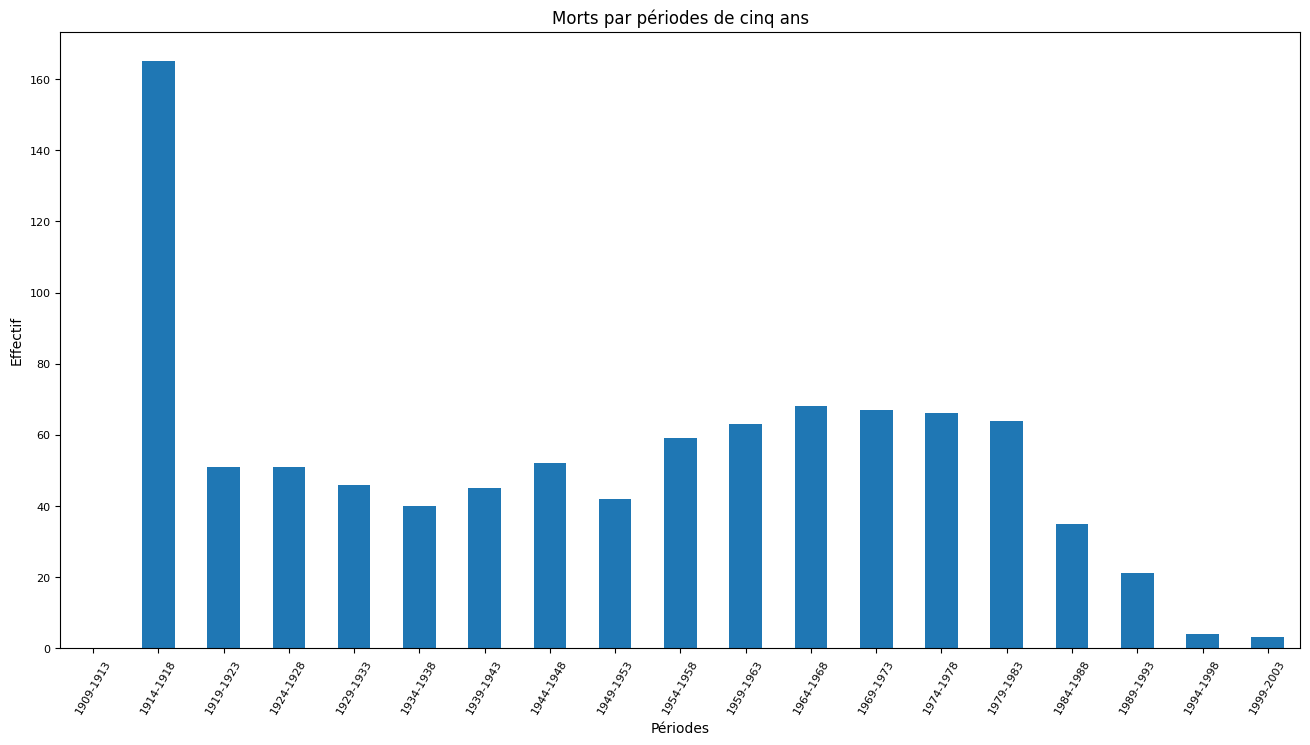

In [66]:
ax = cdf_deaths.groupby(by='periodes').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Morts par périodes de cinq ans')
plt.show()

Nous observons clairement la surmortalité durant 14-18. Cela peut sembler évident mais reste pertinent à l'exercice. 

## Ajouter la représentation des nationalités

In [67]:
### Regrouper et compter avec un fitre sur la nationalité française (FR)
country_fr = pd.DataFrame(cdf_deaths[cdf_deaths['allegiance_clean'] == 'France'].groupby('periodes').size())
country_fr.columns = ['country_fr']
country_fr.tail()



C:\Users\menou\AppData\Local\Temp\ipykernel_24424\3241196984.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  country_fr = pd.DataFrame(cdf_deaths[cdf_deaths['allegiance_clean'] == 'France'].groupby('periodes').size())


,country_fr
periodes,
1979-1983,18
1984-1988,13
1989-1993,9
1994-1998,0
1999-2003,1


In [68]:
### Regrouper et compter les effectifs
top10_allegiances = (
    cdf_deaths.groupby('allegiance_clean')
         .size()
         .reset_index(name='effectif')
         .sort_values('effectif', ascending=False)
         .head(10)
)

print(top10_allegiances)

   allegiance_clean  effectif
10           France       254
31   United Kingdom       124
15            Italy       119
32    United States       116
11          Germany        86
24           Poland        56
1         Australia        44
6            Canada        35
27           Russia        30
2   Austria-Hungary        19


In [69]:
# on définit les alliances
def code_alliances(allegiance_clean):
    # Allies during WW1
    allies = {
        "France", "Italy", "United States", "United Kingdom",
        "Australia", "Canada", "New Zealand", "Belgium",
        "Russian Empire", "Russia", "South Africa", "Ireland",
        "Portugal", "Romania", "Serbia"
    }

    # Central Powers during WW1
    central_powers = {
        "Germany", "German Empire", "German Reich", "Nazi Germany",
        "Austria-Hungary", "Austria", "Bulgaria", "Ottoman Empire",
        "Kingdom of Saxony", "Kingdom of Prussia", "Hungary", "Kingdom of Bavaria"
    }

    if allegiance_clean in allies:
        return "Allies"
    elif allegiance_clean in central_powers:
        return "Central Powers"
    else:
        return "Other"

In [70]:
cdf_deaths['alliance'] = cdf_deaths['allegiance_clean'].apply(code_alliances)


In [71]:
# on regarde la distribution

alliance_counts = (
    cdf_deaths['alliance']
    .value_counts()
    .reset_index(name='effectif')
    .rename(columns={'index': 'alliance'})
)

print(alliance_counts)


         alliance  effectif
0          Allies       752
1  Central Powers       121
2           Other        69


In [72]:
# Group by birth decade and alliance
cdf_deaths['periodes'] = (cdf_deaths['deathYear'] // 5) * 5

merged = (
    cdf_deaths.groupby(['periodes', 'alliance'])
    .size()
    .unstack(fill_value=0)
)

merged.index = merged.index.map(str)


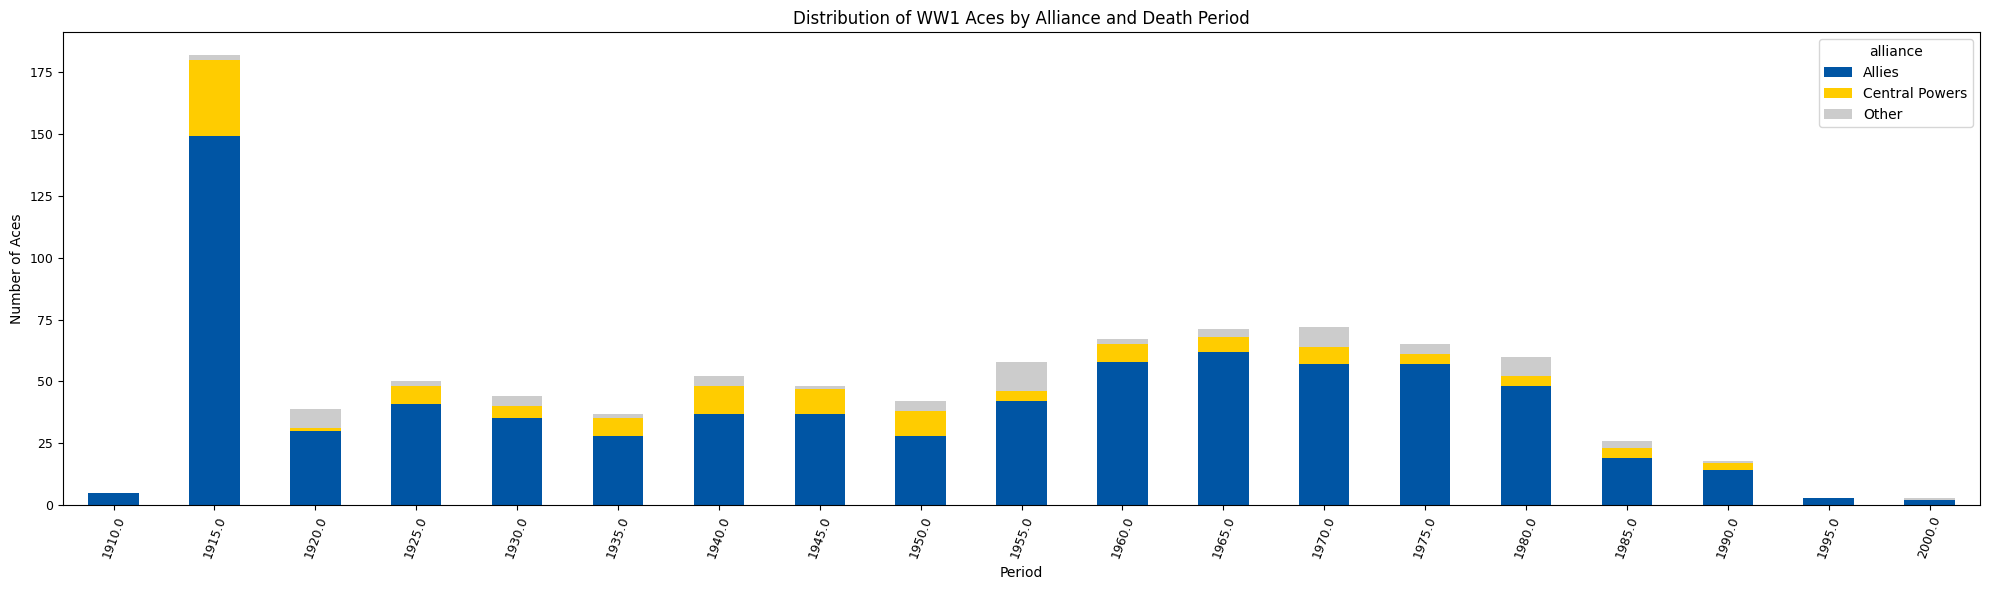

In [73]:
### Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
ax = merged.plot.bar(
    stacked=True,
    rot=70,
    fontsize=9,
    figsize=(20, 6),
    color=['#0055A4', '#FFCC00', '#CCCCCC'] 
)
plt.title("Distribution of WW1 Aces by Alliance and Death Period")
plt.xlabel("Period")
plt.ylabel("Number of Aces")
plt.tight_layout()
plt.show()

## Analyse des données

In [88]:
# on veut comparer les proportions des trois dernières périodes par rapport aux autres
last_3 = merged_2.tail(3)
last_3_total = last_3['tot'].sum()

In [89]:
rest = merged_2.iloc[:-3]
rest_total = rest['tot'].sum()

In [90]:
total_all = last_3_total + rest_total

last_3_prop = round(last_3_total / total_all, 2)
rest_prop = round(rest_total / total_all, 2)


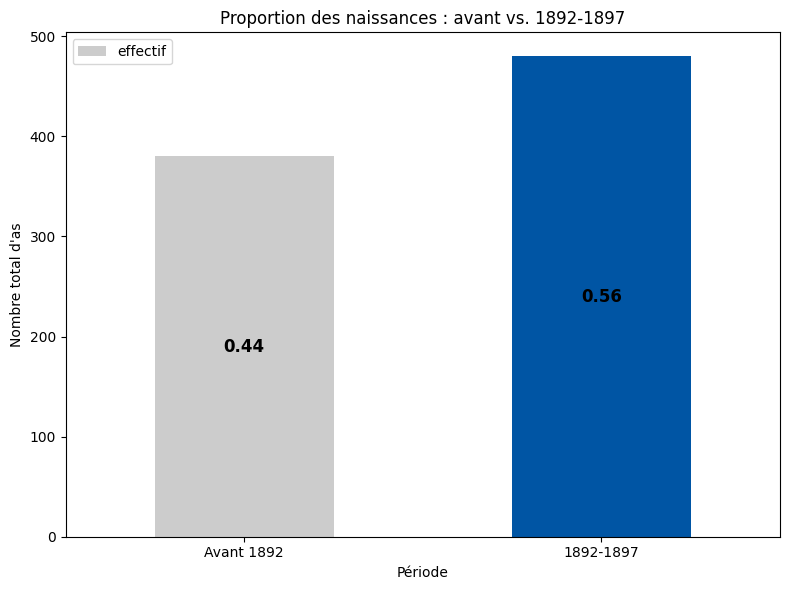

In [95]:
compare_df = pd.DataFrame({
    'période': ['Avant 1892', '1892-1897'],
    'effectif': [rest_total, last_3_total]
})

ax = compare_df.plot.bar(
    x='période',
    y='effectif',
    color=['#CCCCCC', '#0055A4'],
    rot=0,
    figsize=(8, 6)
)

total_all = rest_total + last_3_total
props = [round(rest_total / total_all, 2), round(last_3_total / total_all, 2)]

for bar, prop in zip(ax.patches, props):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2,
        f"{prop}",
        ha='center',
        va='center',
        color='black',
        weight='bold',
        size=12
    )

plt.title("Proportion des naissances : avant vs. 1892-1897")
plt.xlabel("Période")
plt.ylabel("Nombre total d'as")
plt.tight_layout()
plt.show()



In [98]:
# On compte combien de période les deux catégories comprennent
num_rest_periods = len(merged_2.iloc[:-3])
num_last_periods = len(merged_2.tail(3))


print(f"Le groupe 'Avant 1892' comprend {num_rest_periods} périodes de 2 ans et équivaut à 44%.")
print(f"Le groupe '1892–1897' comprend {num_last_periods} périodes de 2 ans et équivaut à 56%.")


Le groupe 'Avant 1892' comprend 16 périodes de 2 ans et équivaut à 44%.
Le groupe '1892–1897' comprend 3 périodes de 2 ans et équivaut à 56%.
